# Notes

We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or from a local path(see Sec. 2).

Welcome to join [IDEA](https://idea.edu.cn/en)([中文网址](https://idea.edu.cn/))!

In [63]:
!conda install -c pytorch pytorch torchvision
!pip install -r requirements.txt
!python models/dino/ops/setup.py build install

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::scikit-image==0.19.3=py310h6a678d5_1
  - defaults/linux-64::navigator-updater==0.3.0=py310h06a4308_0
  - defaults/linux-64::conda==23.3.1=py310h06a4308_0
  - defaults/linux-64::anaconda-project==0.11.1=py310h06a4308_0
  - defaults/linux-64::scikit-learn==1.2.1=py310h6a678d5_0
  - defaults/linux-64::scikit-learn-intelex==2023.0.2=py310h06a4308_0
  - defaults/linux-64::statsmodels==0.13.5=py310ha9d4c09_1
  - defaults/linux-64::hvplot==0.8.2=py310h06a4308_0
  - defaults/linux-64::anaconda-navigator==2.4.0=py310h06a4308_0
  - defaults/linux-64::panel==0.14.3=py310h06a4308_0
  - defaults/linux-64::holoviews==1.15.4=py310h06a4308_0
  - defaults/linux-64::huggingface_hub==0.10.1=py310h06a4308_0
  - defaults/linux-64::datashader==0.14.4=py310h06a4308_0
  - defaults/linux-64::imbalanced-learn==0.10.1=py310h06a4308_0
  - de

In [55]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

# 0. Initialize and Load Pre-trained Models

In [56]:
model_config_path = "config/DINO/DINO_4scale.py" # change the path of the model config file
model_checkpoint_path = "checkpoints/checkpoint0023_4scale.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.

In [57]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

ModuleNotFoundError: No module named 'MultiScaleDeformableAttention'

In [4]:
# load coco names
with open('util/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

# 1. Visualize images from a dataloader
## 1.1 Load Datasets

In [ ]:
args.dataset_file = 'coco'
args.coco_path = "/comp_robot/cv_public_dataset/COCO2017/" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)   

## 1.2 Get an Example and Visualize it

In [6]:
image, targets = dataset_val[0]

In [ ]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

## 1.3 Visualize Model Predictions

In [ ]:
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

In [9]:
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

In [ ]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# 2. Visualize Custom Images

In [5]:
from PIL import Image
import datasets.transforms as T

In [6]:
image = Image.open("./figs/idea.jpg").convert("RGB") # load image

In [7]:
# transform images
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

In [ ]:
# predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

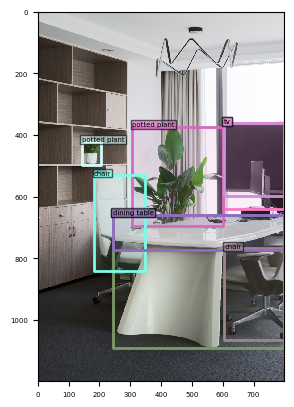

In [9]:
# visualize outputs
thershold = 0.3 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=100)

# EVALUATION IMAGES
https://www.neuralception.com/cocodatasetapi/

In [37]:
from pycocotools.coco import COCO
import json

path = "./data/coco/annotations/instances_val2017.json"
f = open(path)
anns = json.load(f)

ann_file = "./data/coco/annotations/instances_val2017.json"
coco=COCO(ann_file)

category_ids = coco.getCatIds(['bicycle'])
print(category_ids)

image_ids = coco.getImgIds(catIds=category_ids)
print(image_ids)

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
[2]
[184324, 546823, 343561, 169996, 277005, 549390, 384527, 8211, 93717, 468505, 45596, 274460, 473118, 370208, 476704, 67616, 356387, 162858, 492077, 439854, 472623, 203317, 429109, 259640, 157756, 167486, 289343, 227399, 301135, 428111, 228436, 226903, 403565, 242287, 226417, 70774, 319607, 10363, 76416, 185472, 125572, 558213, 309391, 488592, 361103, 40083, 72852, 378515, 507037, 470173, 266400, 388258, 463522, 573094, 61108, 426166, 531134, 338625, 152771, 97988, 8899, 177861, 296649, 7386, 107226, 119516, 424162, 196843, 15597, 55022, 279278, 441586, 135410, 59635, 259830, 274687, 261888, 233727, 76547, 251140, 356612, 306437, 65288, 394510, 374545, 164115, 132375, 378139, 190753, 411938, 184611, 388903, 99114, 351530, 414510, 291634, 224051, 350003, 122166, 301376, 185157, 65350, 350023, 281929, 74058, 130386, 139099, 254814, 210273, 357737, 448365, 13177, 210299, 295809, 101762, 82821, 193926, 49

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


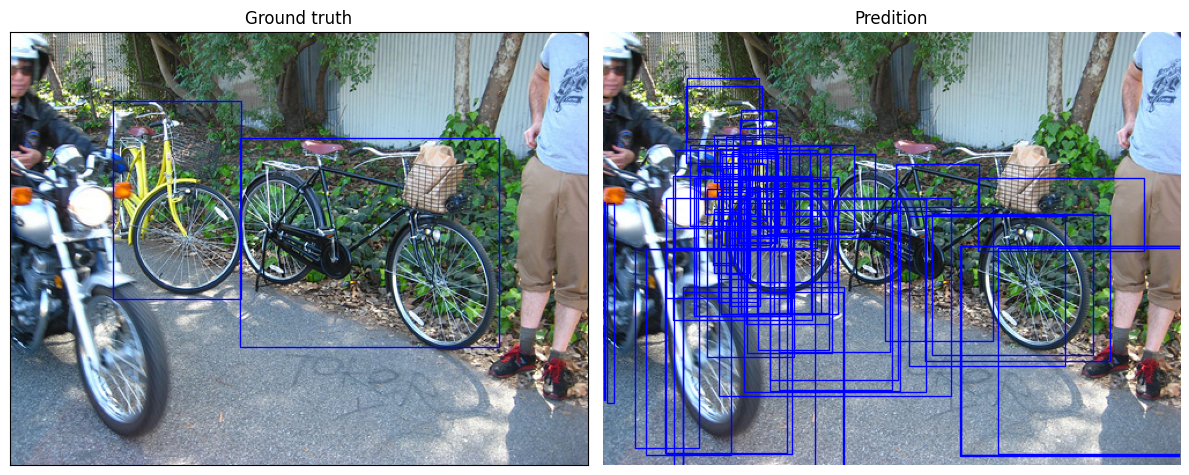

In [77]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
import json

# Set the image ID and category ID
image_id = 11149
category_id = 2

# Set the path to the COCO validation images folder and load the specific image you want to visualize
images_path = "./data/coco/val2017/"
image_name = str(image_id).zfill(12) + ".jpg"
image = Image.open(images_path + image_name)

# Load the JSON file containing the annotations from the COCO validation set 2017
ann_file_coco = "./data/coco/annotations/instances_val2017.json"
coco = COCO(ann_file_coco)
annotation_ids_coco = coco.getAnnIds(imgIds=image_id, catIds=[category_id])
anns_coco = coco.loadAnns(annotation_ids_coco)

# Load the JSON file containing the annotations predicted from the model
ann_file_pred = "./logs/DINO/R50-MS4-%j/results0.json"
with open(ann_file_pred, 'r') as f:
    annotations_pred = json.load(f)

# Retrieve the annotations for the given image ID and category ID
anns_pred = [ann for ann in annotations_pred if ann['image_id'] == image_id and ann['category_id'] == category_id]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the image with annotations
ax1.imshow(image)
ax1.set_title("Ground truth")

# Draw boxes and add labels to each box
for ann in anns_coco:
    box = ann['bbox']
    bb = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor="blue", facecolor="none")
    ax1.add_patch(bb)
ax1.set_xticks([])
ax1.set_yticks([])

# Plot the image with only the bounding boxes
ax2.imshow(image)
ax2.set_title("Predition")

# Draw boxes on the second subplot
for ann in anns_pred:
    box = ann['bbox']
    bb = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor="blue", facecolor="none")
    ax2.add_patch(bb)
ax2.axis('off')

plt.tight_layout()
plt.show()


loading annotations into memory...
Done (t=0.34s)
creating index...
index created!


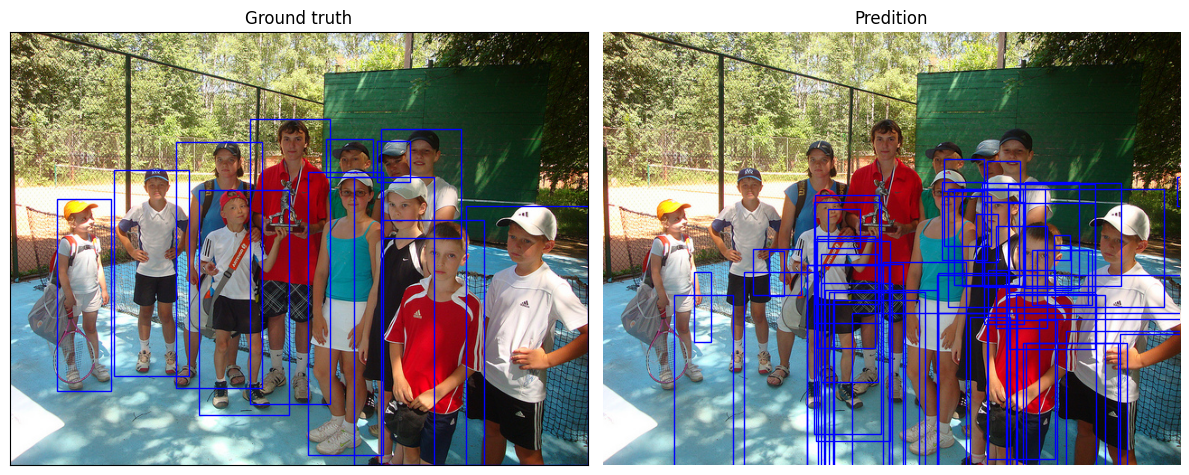

In [78]:
# Set the image ID and category ID
image_id = 1000
category_id = 1

# Set the path to the COCO validation images folder and load the specific image you want to visualize
images_path = "./data/coco/val2017/"
image_name = str(image_id).zfill(12) + ".jpg"
image = Image.open(images_path + image_name)

# Load the JSON file containing the annotations from the COCO validation set 2017
ann_file_coco = "./data/coco/annotations/instances_val2017.json"
coco = COCO(ann_file_coco)
annotation_ids_coco = coco.getAnnIds(imgIds=image_id, catIds=[category_id])
anns_coco = coco.loadAnns(annotation_ids_coco)

# Load the JSON file containing the annotations predicted from the model
ann_file_pred = "./logs/DINO/R50-MS4-%j/results0.json"
with open(ann_file_pred, 'r') as f:
    annotations_pred = json.load(f)

# Retrieve the annotations for the given image ID and category ID
anns_pred = [ann for ann in annotations_pred if ann['image_id'] == image_id and ann['category_id'] == category_id]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the image with annotations
ax1.imshow(image)
ax1.set_title("Ground truth")

# Draw boxes and add labels to each box
for ann in anns_coco:
    box = ann['bbox']
    bb = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor="blue", facecolor="none")
    ax1.add_patch(bb)
ax1.set_xticks([])
ax1.set_yticks([])

# Plot the image with only the bounding boxes
ax2.imshow(image)
ax2.set_title("Predition")

# Draw boxes on the second subplot
for ann in anns_pred:
    box = ann['bbox']
    bb = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor="blue", facecolor="none")
    ax2.add_patch(bb)
ax2.axis('off')

plt.tight_layout()
plt.show()